# Hypothesis Testing with Insurance Data

## Importing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
df = pd.read_csv(r"C:\Users\aliss\Data\US Health Insurance Dataset.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Do smokers have higher insurance charges than non-smokers?

### Hypothesis

Null Hypothesis "Smokers have the potential of having higher insurance charges"

Alternate Hypothesis: "Smokers due to health risks have higher insurance charges"

### T-Testing

In [3]:
sample = df.sample(n=50,random_state=42)
non_charges = sample.loc[ sample['smoker']=='no',"charges"]
smoker_charges = sample.loc[ sample['smoker']=='yes',"charges"]
## Getting means for gender height
print(f"For Smokers (n={len(smoker_charges)}): Mean={np.mean(smoker_charges):.2f}")
print(f"For Non-Smokers (n={len(non_charges)}): Mean={np.mean(non_charges):.2f}")

For Smokers (n=11): Mean=35439.40
For Non-Smokers (n=39): Mean=7309.48


In [4]:
zscores_n = stats.zscore(non_charges)
outliers_n = abs(zscores_n)>3
np.sum(outliers_n)

0

In [5]:
zscores_s = stats.zscore(smoker_charges)
outliers_s = abs(zscores_s)>3
np.sum(outliers_s)

0

In [6]:
# normal test non-smokers
result_n = stats.normaltest(non_charges)
result_n

NormaltestResult(statistic=2.6262187199374125, pvalue=0.26898239167805005)

In [7]:
# normal test smokers
result_s = stats.normaltest(smoker_charges)
result_s

C:\Users\aliss\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NormaltestResult(statistic=2.209358578032982, pvalue=0.331317122245031)

In [8]:
result = stats.levene(smoker_charges, non_charges)
result

LeveneResult(statistic=18.397400827816167, pvalue=8.621214599569028e-05)

In [9]:
## Final t-test, after confirming we meet the assumptions
result = stats.ttest_ind(smoker_charges, non_charges)
result

Ttest_indResult(statistic=13.237119558105961, pvalue=1.2286151200596125e-17)

In [10]:
## is our result significant
print(f"p-value={result.pvalue:.10f}")
print(f"Significant: {result.pvalue <.05}")

p-value=0.0000000000
Significant: True


Based on the testing it means we will need to reject the null hypothesis and accept the alternative hypothesis
>Smokers due to health risks have higher insurance charges

### Visual

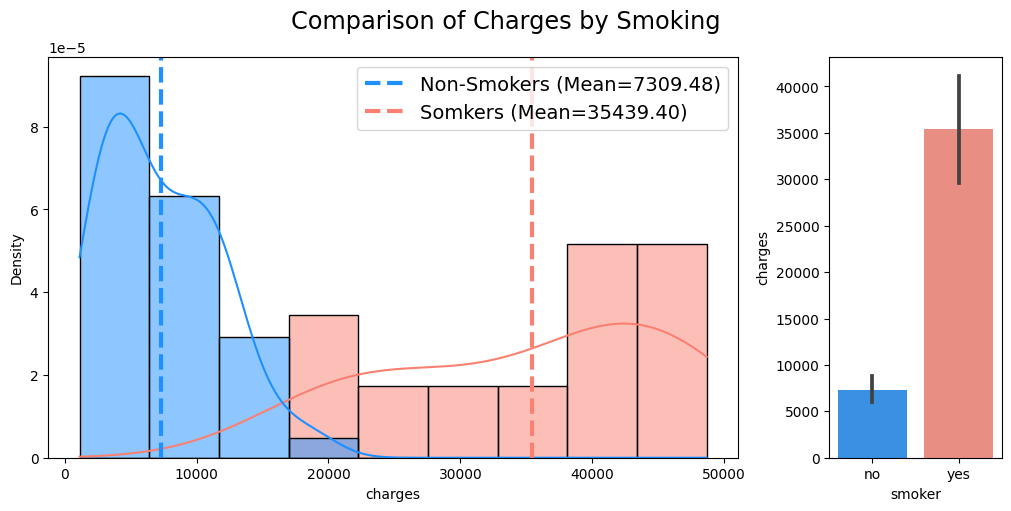

In [11]:
gender_palette={'no':'dodgerblue', "yes":'salmon'}
## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=sample, x='charges',fill=True,hue='smoker',kde=True,
                  stat='density',common_norm=False,ax=ax,
                  palette=gender_palette)

ax.axvline(np.mean(non_charges), ls='--',lw=3, 
           label=f"Non-Smokers (Mean={np.mean(non_charges):.2f})",color=gender_palette['no'])

ax.axvline(np.mean(smoker_charges), ls='--', lw=3, 
           label=f"Somkers (Mean={np.mean(smoker_charges):.2f})",color=gender_palette['yes'])

ax.legend(prop={"size":14}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=sample, x='smoker',y='charges',ax = ax_bar,palette=gender_palette)
fig.suptitle('Comparison of Charges by Smoking',fontsize='xx-large');

## Are men more likely to smoke than women?

### Hypothesis

Null Hypothesis "Neither men nor women are likely to smoke"

Alternate Hypothesis: "Men are more likely to smoke then women"

### Categorical Hypothesis Testing

In [12]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [13]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

In [14]:
# What was our p-value?
print(p)
p<.05

0.006548143503580697


True

Based on the testing result it looks like there is not a high correlation between sex and smoking
>Neither men nor women are likely to smoke

### Visual

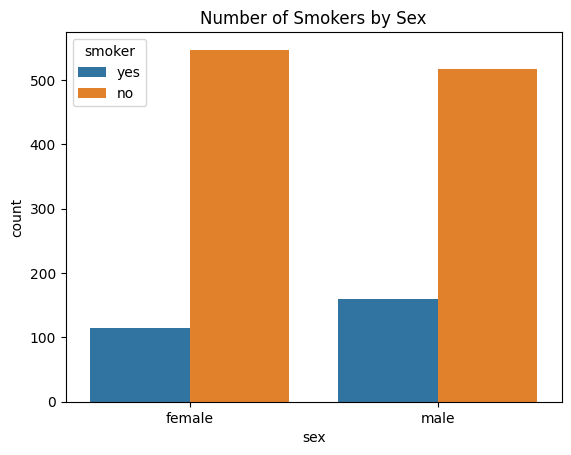

In [15]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers by Sex");

## Do different regions have different charges, on average?

### Hypothesis

Null Hypothesis "Different regions will have comparatively different charges"

Alternate Hypothesis: "Different regions won't have comparatively different charges"

### ANOVA Testing

In [16]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [17]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [18]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


In [19]:
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

In [20]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

In [21]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)

In [22]:
values = df['charges']
labels = df['region']

In [23]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


Based on the testing result it looks like there is not a high correlation between what your insurance charges and where you live
>Different regions won't have comparatively different charges

### Visual

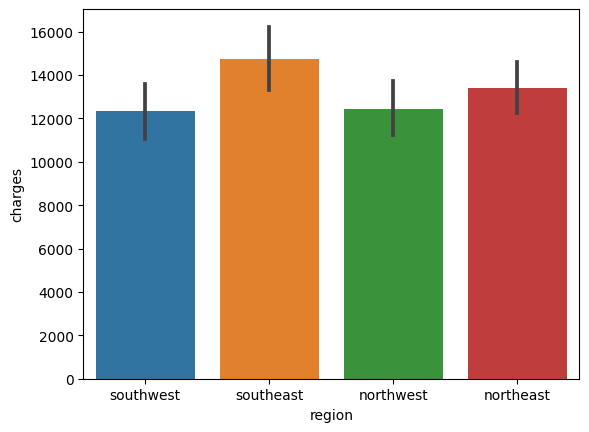

In [24]:
sns.barplot(data=df, x='region',y='charges');